# Observe behavior before and during a light pulse

In [1]:
import load_data as ld
import helpers as hp
import nan_imputation as ni
import light_pusle as lp
import os
import pandas as pd
import numpy as np

In [2]:
import importlib
importlib.reload(lp)

<module 'light_pusle' from 'c:\\Users\\msgar\\OneDrive\\Documents\\EPFL\\Cours\\MA1\\Machine_Learning\\ML_project2\\ML-Project-2\\light_pusle.py'>

### Load data and remove NaN

In [3]:
# Load data
repo_root = hp.find_repo_root()
optogenetics_path = os.path.join(repo_root, 'Data', 'Optogenetics')
opto_data = ld.load_optogenetics(optogenetics_path)

In [4]:
# Remove rows with NaN values
rows_to_check = slice(2, 4)
cut_nan_dict = {name: ni.cut_array(array, rows_to_check) for name, array in opto_data.items()}

### Create plots that compare speed and changed pixels before and during light pulse

In [5]:
# Process each worm in `cut_nan_dict`
for worm_name, worm_array in cut_nan_dict.items():    
    # Convert NumPy array to DataFrame
    worm_df = pd.DataFrame(
        worm_array.T, 
        columns=['Frame', 'Speed', 'X', 'Y', 'Changed Pixels', 'Light_Pulse', 'Category']
    )
    # Detect light pulses
    light_pulses = lp.detect_light_pulses(worm_df, pulse_column='Light_Pulse', pulse_length_min=8, pulse_length_max=15)
    if light_pulses:
        
        # Compare behavior before and during light pulses
        behavior_comparisons = lp.compare_behavior_before_during(worm_df, light_pulses)
        #print(behavior_comparisons)
        
        # Visualize changes (Speed and Changed Pixels)
        for feature in ['Speed', 'Changed Pixels']:
            lp.plot_behavior_changes(behavior_comparisons, feature, worm_name)
    else:
        print(f"No valid light pulses detected for {worm_name}.")

### Train a classifier
Compare behavior before and during light pulse

Train classifier without light pulse information

Detect light pulses using behavior only

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize list to store all behavior comparisons for all worms
all_comparisons = []

# Process each worm in `cut_nan_dict`
for worm_name, worm_array in cut_nan_dict.items():
    # Convert NumPy array to DataFrame
    worm_df = pd.DataFrame(
        worm_array.T, 
        columns=['Frame', 'Speed', 'X', 'Y', 'Changed Pixels', 'Light Pulse', 'Category']
    )
    # Detect light pulses
    light_pulses = lp.detect_light_pulses(worm_df, pulse_column='Light Pulse', pulse_length_min=8, pulse_length_max=15)
    if light_pulses:
        # Compare behavior before and during light pulses
        behavior_comparisons = lp.compare_behavior_before_during(worm_df, light_pulses)
        behavior_comparisons['Worm Type'] = worm_df['Category'].iloc[0]  # Add ATR+ or ATR- information
        behavior_comparisons['Worm Name'] = worm_name  # Add worm name
        all_comparisons.append(behavior_comparisons)

# Combine all behavior comparisons into a single DataFrame
comparison_df = pd.concat(all_comparisons, ignore_index=True)

# Assign labels: Reactive (ATR+) = 1, Non-Reactive (ATR-) = 0
comparison_df['Reactive'] = comparison_df['Worm Type'].apply(lambda x: 1 if x == 1 else 0)

# Select features and labels for the classifier
features = comparison_df[['Speed Before', 'Speed During', 'Changed Pixels Before', 'Changed Pixels During',
                          'Distance Before', 'Distance During']]
labels = comparison_df['Reactive']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Feature Importances
feature_importances = pd.DataFrame({
    'Feature': features.columns,
    'Importance': classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

# Save feature importances
repo_root = hp.find_repo_root()
output_path = os.path.join(repo_root, 'Data', 'Plots', 'light_pulses', 'feature_importances.csv')
feature_importances.to_csv(output_path, index=False)
print(f"Feature importances saved to: {output_path}")


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       300
           1       0.97      0.96      0.96       249

    accuracy                           0.97       549
   macro avg       0.97      0.97      0.97       549
weighted avg       0.97      0.97      0.97       549

Accuracy: 0.97

Feature Importances:
                 Feature  Importance
3  Changed Pixels During    0.416911
1           Speed During    0.324342
5        Distance During    0.079878
2  Changed Pixels Before    0.070371
4        Distance Before    0.054480
0           Speed Before    0.054018
Feature importances saved to: c:\Users\msgar\OneDrive\Documents\EPFL\Cours\MA1\Machine_Learning\ML_project2\ML-Project-2\Data\Plots\light_pulses\feature_importances.csv


C:\Users\msgar\AppData\Local\Temp\ipykernel_22176\1988249442.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


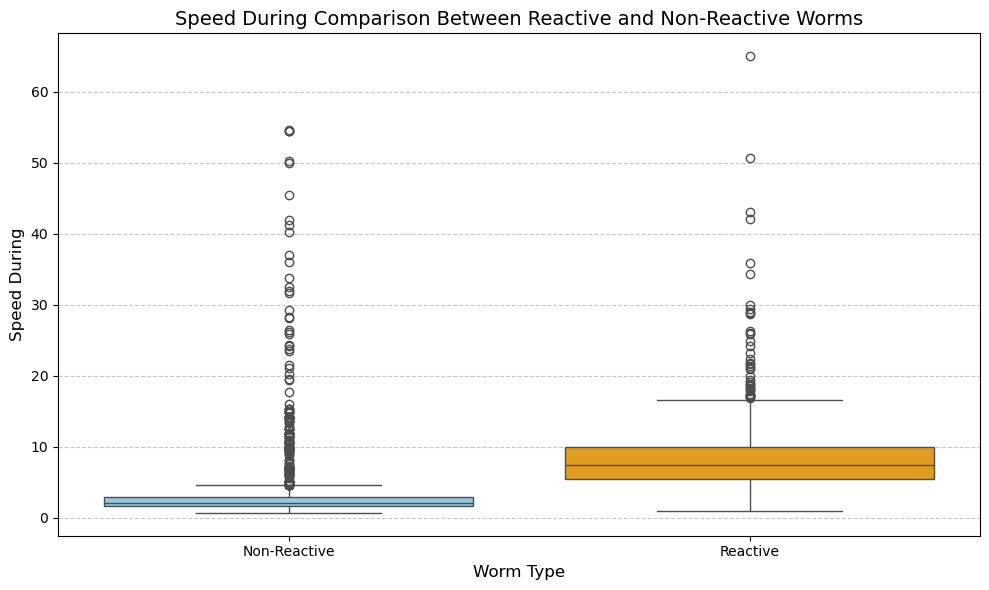

C:\Users\msgar\AppData\Local\Temp\ipykernel_22176\1988249442.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


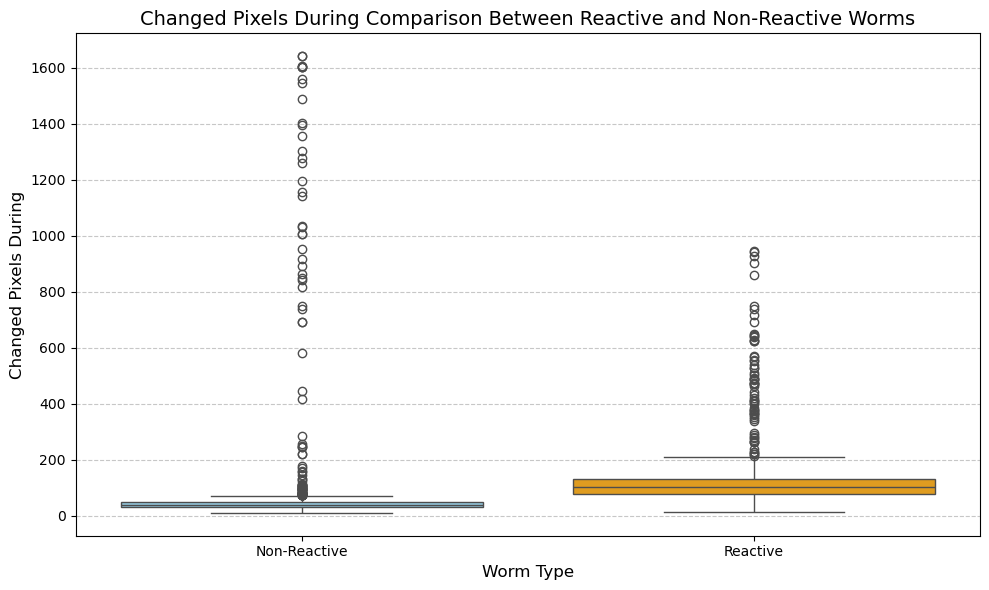

In [7]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Map worm type to descriptive labels
comparison_df['Worm Type'] = comparison_df['Worm Type'].map({0: 'Non-Reactive', 1: 'Reactive'})

# Define the features to visualize
features = ['Speed During', 'Changed Pixels During']

# Iterate through each feature to create boxplots
for feature in features:
    # Create the boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=comparison_df,
        x='Worm Type',
        y=feature,
        palette={"Non-Reactive": "skyblue", "Reactive": "orange"}  # Keys match string labels
    )
    plt.title(f"{feature} Comparison Between Reactive and Non-Reactive Worms", fontsize=14)
    plt.xlabel("Worm Type", fontsize=12)
    plt.ylabel(feature, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Save the plot
    output_dir = os.path.join(repo_root, 'Data', 'Plots', 'light_pulses', 'classifier')
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, f"{feature}_comparison_reactive_nonreactive.png")
    plt.savefig(output_path)

    # Close the plot to avoid overlap
    plt.show()
    #plt.close()